In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
!export OMP_NUM_THREADS=1
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

!export TF_ENABLE_ONEDNN_OPTS=0
!export XLA_FLAGS="--xla_gpu_cuda_data_dir=$CONDA_PREFIX/lib"
!echo $CONDA_PREFIX
!echo $LD_LIBRARY_PATH


2024-07-04 12:59:22.754106: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 12:59:22.779503: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 12:59:23.169885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[]


2024-07-04 12:59:23.761678: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


/home/radiology/miniconda3/envs/torch-env



In [2]:
import torch
import torch.nn as nn
# from torchsummary import summary

class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion, stride):
        super(InvertedResidualBlock, self).__init__()

        self.stride = stride
        self.expansion_layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * expansion, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * expansion),
            nn.ReLU6(inplace=True)
        )

        self.depthwise_layer = nn.Sequential(
            nn.Conv2d(in_channels * expansion, in_channels * expansion, kernel_size=3, stride=stride, padding=1, groups=in_channels * expansion, bias=False),
            nn.BatchNorm2d(in_channels * expansion),
            nn.ReLU6(inplace=True)
        )

        self.pointwise_layer = nn.Sequential(
            nn.Conv2d(in_channels * expansion, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.expansion_layer(x)
        out = self.depthwise_layer(out)
        out = self.pointwise_layer(out)

        # if self.stride == 1:
        #     out = out + x

        return out

class InvertedResidualBlockTranspose(nn.Module):
    def __init__(self, in_channels, out_channels, t=6, stride=1):
        super(InvertedResidualBlockTranspose, self).__init__()

        self.stride = stride

        self.expansion_layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * t, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True)
        )

        self.depthwise_layer_transpose = nn.Sequential(
            nn.ConvTranspose2d(in_channels * t, in_channels * t, kernel_size=3, stride=stride, padding=1,
                               output_padding=(0 if stride == 1 else 1), groups=in_channels * t, bias=False),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True)
        )

        self.pointwise_layer_transpose = nn.Sequential(
            nn.ConvTranspose2d(in_channels * t, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.expansion_layer(x)
        out = self.depthwise_layer_transpose(out)
        out = self.pointwise_layer_transpose(out)

        return out


class MobileNetV2CAE(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(MobileNetV2CAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),
            InvertedResidualBlock(32, 16, 1, 1),
            InvertedResidualBlock(16, 24, 6, 2),
            InvertedResidualBlock(24, 24, 6, 1),
            InvertedResidualBlock(24, 32, 6, 2),
            InvertedResidualBlock(32, 32, 6, 1),
            InvertedResidualBlock(32, 32, 6, 1),
            InvertedResidualBlock(32, 64, 6, 2),
            InvertedResidualBlock(64, 64, 6, 1),
            InvertedResidualBlock(64, 64, 6, 1),
            InvertedResidualBlock(64, 64, 6, 1),
            InvertedResidualBlock(64, 96, 6, 1),
            InvertedResidualBlock(96, 96, 6, 1),
            InvertedResidualBlock(96, 96, 6, 1),
            InvertedResidualBlock(96, 160, 6, 2),
            InvertedResidualBlock(160, 160, 6, 1),
            InvertedResidualBlock(160, 160, 6, 1),
            InvertedResidualBlock(160, 320, 6, 1)
        )

        self.decoder = nn.Sequential(
            InvertedResidualBlockTranspose(320, 160, 6, 1),
            InvertedResidualBlockTranspose(160, 160, 6, 1),
            InvertedResidualBlockTranspose(160, 160, 6, 2),
            InvertedResidualBlockTranspose(160, 96, 6, 1),
            InvertedResidualBlockTranspose(96, 96, 6, 1),
            InvertedResidualBlockTranspose(96, 96, 6, 1),
            InvertedResidualBlockTranspose(96, 64, 6, 1),
            InvertedResidualBlockTranspose(64, 64, 6, 1),
            InvertedResidualBlockTranspose(64, 64, 6, 1),
            InvertedResidualBlockTranspose(64, 64, 6, 1),
            InvertedResidualBlockTranspose(64, 32, 6, 2),
            InvertedResidualBlockTranspose(32, 32, 6, 1),
            InvertedResidualBlockTranspose(32, 32, 6, 1),
            InvertedResidualBlockTranspose(32, 24, 6, 2),
            InvertedResidualBlockTranspose(24, 24, 6, 1),
            InvertedResidualBlockTranspose(24, 16, 6, 2), # Change stride from 1 to 2
            nn.ConvTranspose2d(16, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = MobileNetV2CAE(in_channels=3)

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# print(summary(model, input_size=(3, 32, 32), device=device.type))

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt


# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Hyperparameters
num_epochs = 5
learning_rate = 0.001

# Instantiate the model
model = MobileNetV2CAE(in_channels=3).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Training the model
model.train()
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        images = images.float()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [100/1563], Loss: 0.2513
Epoch [1/5], Step [200/1563], Loss: 0.2723
Epoch [1/5], Step [300/1563], Loss: 0.2641
Epoch [1/5], Step [400/1563], Loss: 0.2556
Epoch [1/5], Step [500/1563], Loss: 0.2110
Epoch [1/5], Step [600/1563], Loss: 0.1975
Epoch [1/5], Step [700/1563], Loss: 0.2067
Epoch [1/5], Step [800/1563], Loss: 0.2083
Epoch [1/5], Step [900/1563], Loss: 0.1960
Epoch [1/5], Step [1000/1563], Loss: 0.1865
Epoch [1/5], Step [1100/1563], Loss: 0.2026
Epoch [1/5], Step [1200/1563], Loss: 0.1925
Epoch [1/5], Step [1300/1563], Loss: 0.2056
Epoch [1/5], Step [1400/1563], Loss: 0.1841
Epoch [1/5], Step [1500/1563], Loss: 0.1763
Epoch [2/5], Step [100/1563], Loss: 0.1988
Epoch [2/5], Step [200/1563], Loss: 0.1957
Epoch [2/5], Step [300/1563], Loss: 0.1894
Epoch [2/5], Step [400/1563], Loss: 0.1610
Epoch [2/5], Step [500/1563], Loss: 0.1748
Epoch [2/5], Step [600/1563], Loss: 0.1890
Epoch [2/5], Step [700/1563], Loss: 0.1641
Epoch [2/5], Step [800/1563], Loss: 0.1851
Epoch

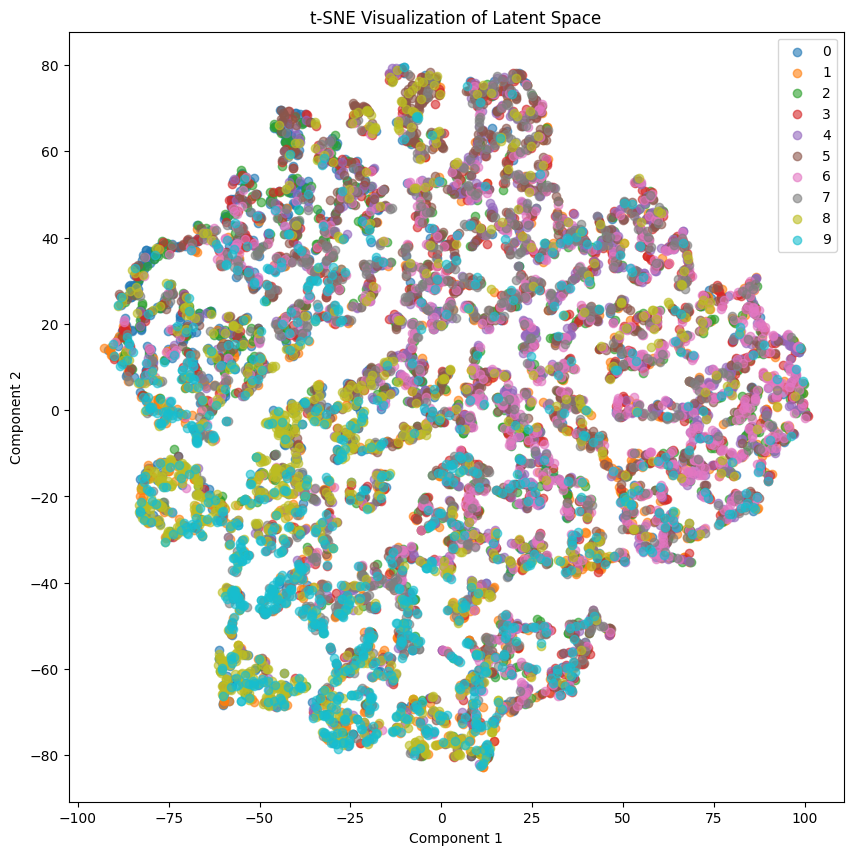

In [11]:
model.eval()

latent_space = []
labels = []

with torch.no_grad():
    for i, (images, lbls) in enumerate(test_loader):
        images = images.to(device)
        encoded = model.encoder(images).view(images.size(0), -1).cpu().numpy()
        latent_space.append(encoded)
        labels.extend(lbls)

latent_space = np.vstack(latent_space)
labels = np.array(labels)

tsne = TSNE(n_components=2, random_state=42)
latent_2D = tsne.fit_transform(latent_space)

# Visualize the latent space using t-SNE
plt.figure(figsize=(10, 10))
for i in range(10):
    indices = labels == i
    plt.scatter(latent_2D[indices, 0], latent_2D[indices, 1], label=f'{i}', alpha=0.6)

plt.legend()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Visualization of Latent Space')
plt.show()


In [12]:
model.eval()  # Set the model to evaluation mode

total_loss = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = inputs.cuda(), labels        
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        total_loss += loss.item()
average_loss = total_loss / len(test_loader)
print(f'Average reconstruction loss: {average_loss:.4f}')

NameError: name 'inputs' is not defined

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

classifier = SimpleCNN()
classifier.to(device)

classifier_criterion = nn.CrossEntropyLoss()
classifier_optimizer = optimizer

In [ ]:
from torchvision import models
device = torch.device("cpu")

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        classifier_optimizer.zero_grad()
        
        outputs = classifier(inputs)
        loss = classifier_criterion(outputs, labels)
        loss.backward()
        classifier_optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

def get_predictions(loader):
    classifier.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = classifier(images)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds)
            all_labels.append(labels)
    return torch.cat(all_preds), torch.cat(all_labels)

original_preds, original_labels = get_predictions(train_loader)

def get_reconstructed_predictions(autoencoder, loader):
    autoencoder.eval()
    classifier.eval()
    all_preds = []
    with torch.no_grad():
        for data in loader:
            images, _ = data
            images = images.to(device)
            reconstructions = autoencoder(images)
            outputs = classifier(reconstructions)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds)
    return torch.cat(all_preds)

reconstructed_preds = get_reconstructed_predictions(model, train_loader)

accuracy = (original_preds == reconstructed_preds).sum().item() / original_preds.size(0)
print(f'Accuracy of reconstructed images: {accuracy * 100:.2f}%')